**Reference**: Keras tutorial : https://www.tensorflow.org/tutorials/generative/autoencoder . Chapter 17 of Geron's book.

This file trains an autoencoder with the instances of the normal digit in the training data. 

Then, it measures the reconstruction loss for the digits in the test data.

The reconstruction loss for the instances of the abnormal digit in the test data is higher.

A threshold is determined based on the distribution of the reconstruction losses of the normal training data (threshold = mean + 2.5*std of this distribution).  

Then, if the reconstruction loss of a digit in the test data is higher than this threshold, it is classified as abnormal.

By comparing with the known labels of test data (with T for normal digit(s) and F for abnormal digit(s)), the confusion matrix and the accuracy is calculated. 

In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import mnist
from keras.models import Model
# import cv2

### **Loading the MNIST data and forming arrays of the normal training data, validation data (normal and abnormal, and the test data (normal and abnormal)**

In [114]:
#Labels
# 0 T-shirt/top
# 1 Trouser
# 2 Pullover
# 3 Dress
# 4 Coat
# 5 Sandal
# 6 Shirt
# 7 Sneaker
# 8 Bag
# 9 Ankle boot

nl1 = 5  
nl2 = 7   
nl3 = 9
abn = 4

(x_train_0, y_train_0), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train_0 = x_train_0.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

train_size = x_train_0.shape[0] * 9 // 10

x_train, x_valid, y_train, y_valid = train_test_split(x_train_0, y_train_0, train_size = train_size)

normal_data = x_train[(y_train == nl1) | (y_train == nl2) | (y_train == nl3)]    # Normal training data (Normal digits)
normal_labels = y_train[(y_train == nl1) | (y_train == nl2) | (y_train == nl3)]  

valid_data = x_valid[(y_valid == abn) | (y_valid == nl1) | (y_valid == nl2) |  (y_valid == nl3)]    # Validation data (both normal digits and the abnormal digit)
valid_labels = y_valid[(y_valid == abn) | (y_valid == nl1) | (y_valid == nl2) |  (y_valid == nl3)]

test_data = x_test[(y_test == abn) | (y_test == nl1) | (y_test == nl2) |(y_test == nl3)]   # Test data (both normal digits and the abnormal digit)
test_labels = y_test[(y_test == abn) | (y_test == nl1) | (y_test == nl2) | (y_test == nl3)]

test_labels_T_F = np.where((test_labels == nl1) | (test_labels == nl2) | (test_labels == nl3), True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

valid_labels_T_F = np.where((valid_labels == nl1) | (valid_labels == nl2) |(valid_labels == nl3), True, False) 
# Array of T and F, T where test digits are normal and F where test digits are abnormal

In [115]:
normal_data.shape, normal_labels.shape, valid_data.shape, valid_labels.shape, test_data.shape, test_labels.shape

((16193, 28, 28), (16193,), (2410, 28, 28), (2410,), (4000, 28, 28), (4000,))

In [116]:
normal_test_data = test_data[(test_labels == nl1) | (test_labels == nl2) | (test_labels == nl3)]   # The normal digits in the test data
abnormal_test_data = test_data[test_labels == abn]                          # The abnormal digits in the test data
normal_test_labels = test_labels[(test_labels == nl1) | (test_labels == nl2) | (test_labels == nl3)]   # Their labels
abnormal_test_labels = test_labels[test_labels == abn]                          # Their labels

In [117]:
normal_test_data.shape, abnormal_test_data.shape

((3000, 28, 28), (1000, 28, 28))

In [118]:
normal_valid_data = valid_data[(valid_labels == nl1) | (valid_labels == nl2) | (valid_labels == nl3)]   # The normal digits in the valid data
abnormal_valid_data = valid_data[valid_labels == abn]                           # The abnormal digits in the valid data
normal_valid_labels = valid_labels[(valid_labels == nl1) | (valid_labels == nl2) | (valid_labels == nl3)]   # Their labels
abnormal_valid_labels = valid_labels[valid_labels == abn]                           # Their labels

In [119]:
normal_valid_data.shape, abnormal_valid_data.shape

((1807, 28, 28), (603, 28, 28))

### **Building and training the network** 

In [120]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(256, activation="selu"),
      layers.Dense(128, activation="selu"),
      layers.Dense(64, activation="selu"),
      layers.Dense(16, activation="selu")])

    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="selu"),                                  
      layers.Dense(128, activation="selu"),
      layers.Dense(256, activation="selu"),
      layers.Dense(28*28, activation="sigmoid"),
      layers.Reshape((28, 28))])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [121]:
# autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [122]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("AE_model", monitor="val_loss", save_best_only=True)

history = autoencoder.fit(normal_data, normal_data, 
          epochs=100, 
          batch_size=128,
          validation_data=(normal_valid_data, normal_valid_data),
          callbacks=[checkpoint_cb],
          shuffle=True)

Epoch 1/100
127/127 [==============================] - 3s 17ms/step - loss: 0.3004 - val_loss: 0.2648
Epoch 2/100
127/127 [==============================] - 2s 17ms/step - loss: 0.2596 - val_loss: 0.2477
Epoch 3/100
127/127 [==============================] - 2s 16ms/step - loss: 0.2510 - val_loss: 0.2444
Epoch 4/100
127/127 [==============================] - 2s 16ms/step - loss: 0.2460 - val_loss: 0.2427
Epoch 5/100
127/127 [==============================] - 2s 18ms/step - loss: 0.2419 - val_loss: 0.2377
Epoch 6/100
127/127 [==============================] - 2s 15ms/step - loss: 0.2388 - val_loss: 0.2329
Epoch 7/100
127/127 [==============================] - 2s 16ms/step - loss: 0.2361 - val_loss: 0.2309
Epoch 8/100
127/127 [==============================] - 2s 17ms/step - loss: 0.2343 - val_loss: 0.2296
Epoch 9/100
127/127 [==============================] - 2s 15ms/step - loss: 0.2327 - val_loss: 0.2294
Epoch 10/100
127/127 [==============================] - 2s 15ms/step - loss: 0.231

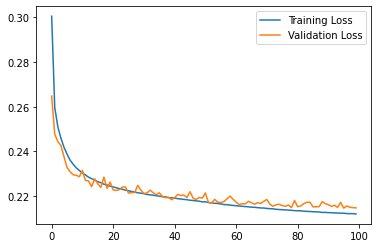

In [123]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

In [124]:
model = autoencoder
model.summary(expand_nested=True, show_trainable=True)

Model: "anomaly_detector_2"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 sequential_4 (Sequential)   (None, 16)                243152    Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| flatten_2 (Flatten)       (None, 784)               0         Y          |
|                                                                          |
| dense_16 (Dense)          (None, 256)               200960    Y          |
|                                                                          |
| dense_17 (Dense)          (None, 128)               32896     Y          |
|                                                                          |
| dense_18 (Dense)          (None, 64)                8256      Y          |
|                                                                          |
| dense_19 (Dense)          (None, 16)          

In [125]:
model_encoder = autoencoder.encoder
# model_encoder.summary(expand_nested=True, show_trainable=True)

In [126]:
model_decoder = autoencoder.decoder
# model_decoder.summary(expand_nested=True, show_trainable=True)

In [127]:
model_layers = np.array(model.layers)
n_layers = model_layers.shape[0] 
# np.concatenate((np.arange(n_layers).reshape(n_layers,1), model_layers.reshape(n_layers,1)), axis = 1)

### **The original and reconstructed images for the first 30 instances of the normal training data, validation data, normal validation data, abnormal validation data, test data, normal test data, and abnormal test data**

In [128]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [129]:
def show_reconstructions(autoencoder, images, n_images=5):
    encoded_data = autoencoder.encoder(images[:n_images]).numpy()
    decoded_data = autoencoder.decoder(encoded_data).numpy()
    reconstructions = decoded_data
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

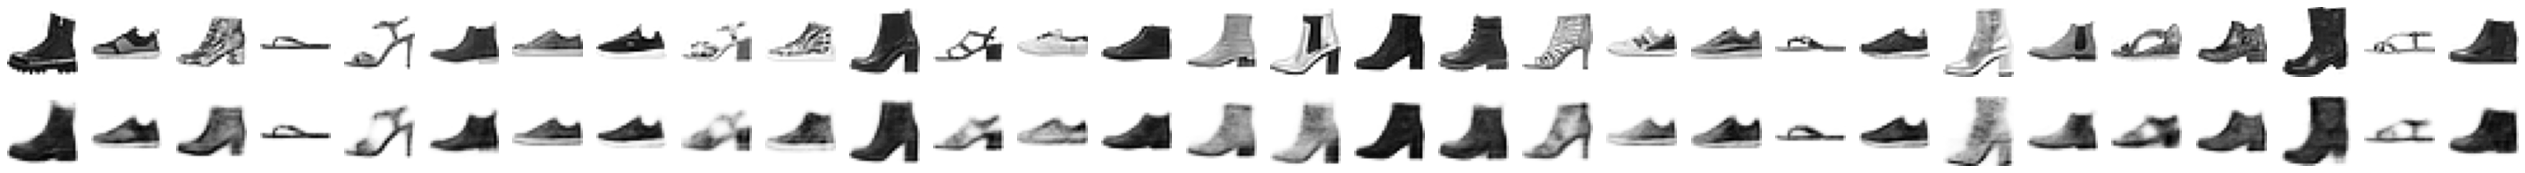

In [130]:
show_reconstructions(autoencoder, normal_data, 30)
plt.show()

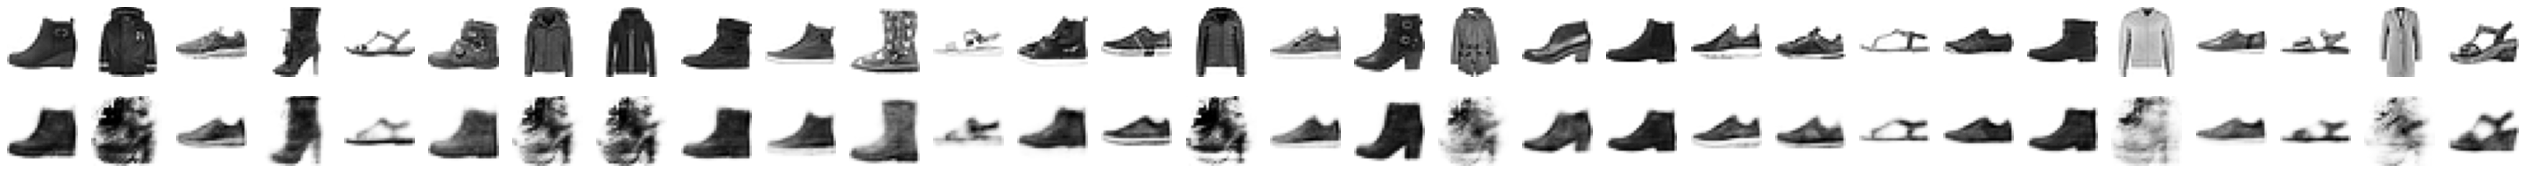

In [131]:
show_reconstructions(autoencoder, valid_data, 30)
plt.show()

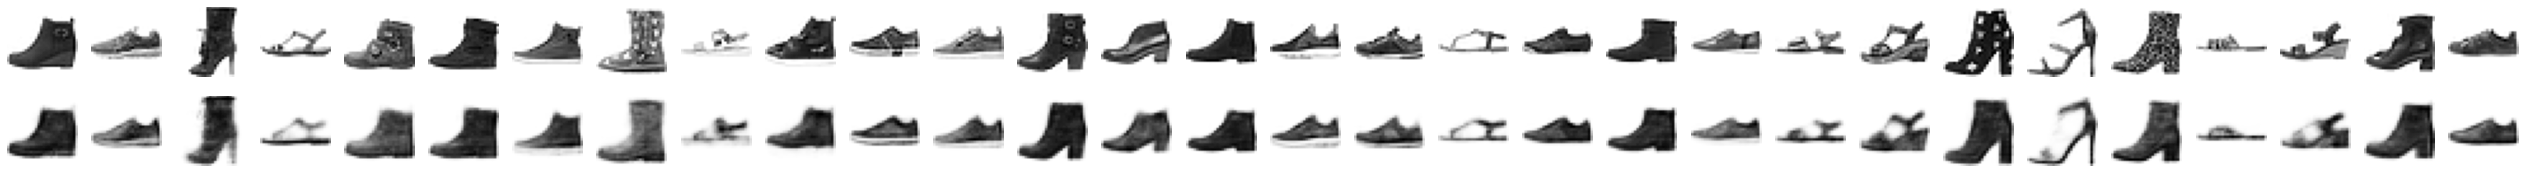

In [132]:
show_reconstructions(autoencoder, normal_valid_data, 30)
plt.show()

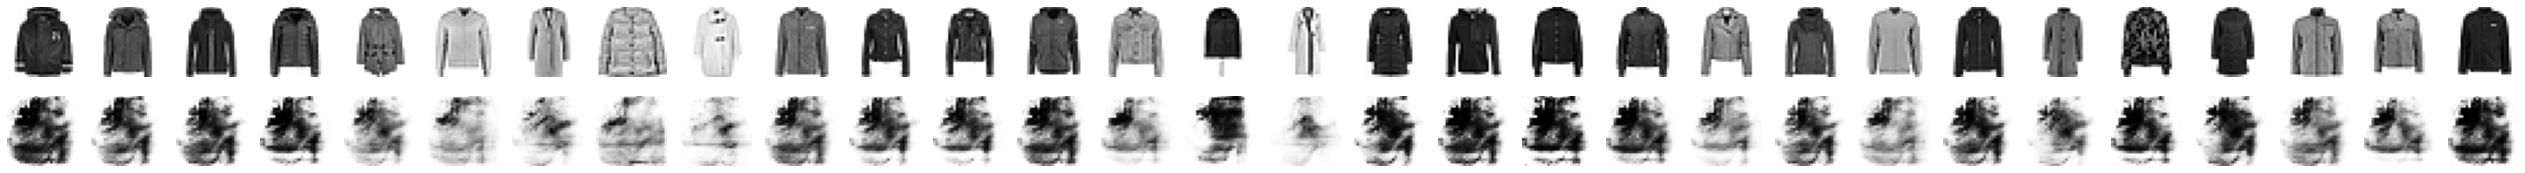

In [133]:
show_reconstructions(autoencoder, abnormal_valid_data, 30)
plt.show()

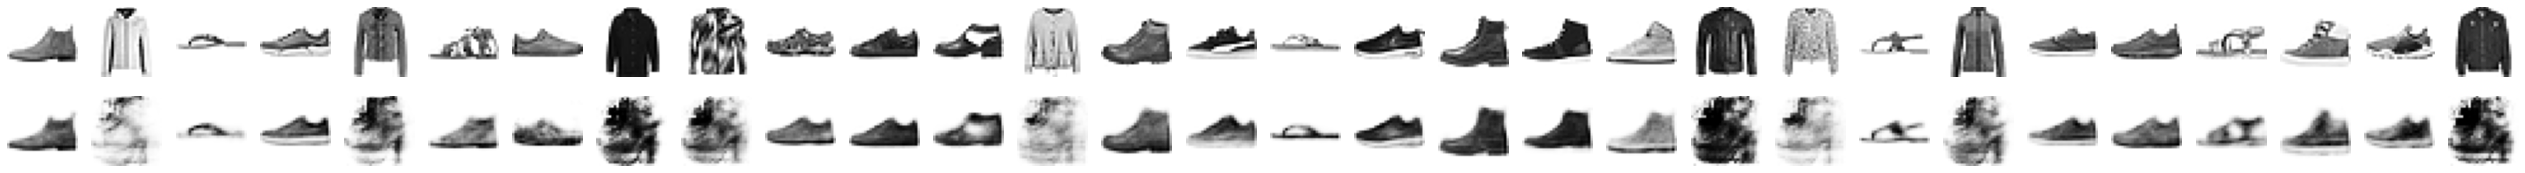

In [134]:
show_reconstructions(autoencoder, test_data, 30)
plt.show()

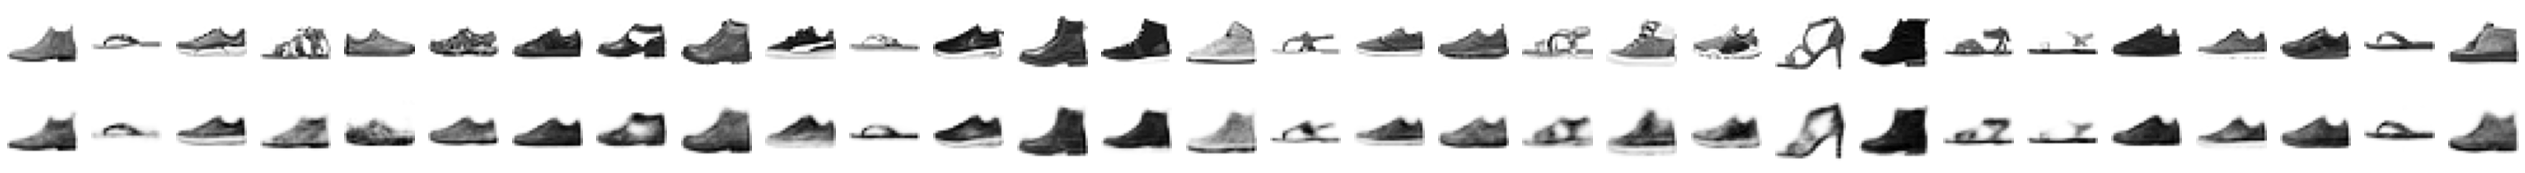

In [135]:
show_reconstructions(autoencoder, normal_test_data, 30)
plt.show()

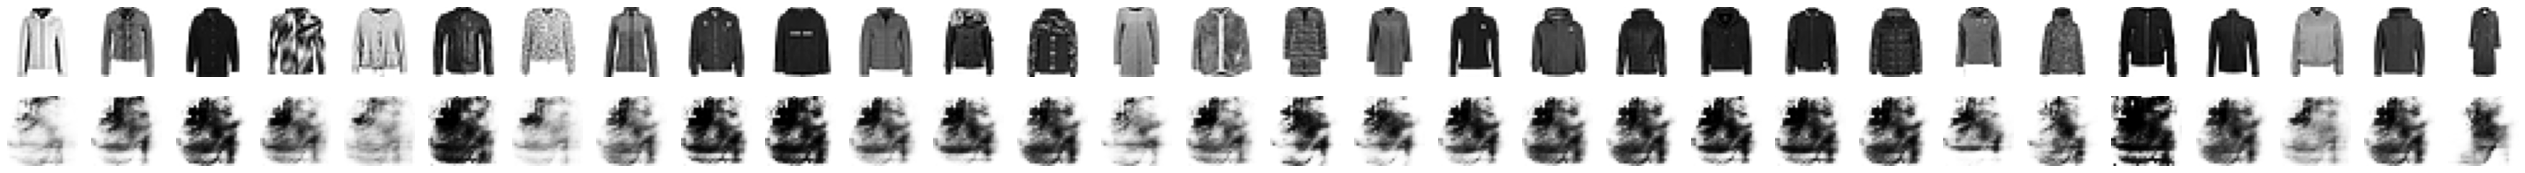

In [136]:
show_reconstructions(autoencoder, abnormal_test_data, 30)
plt.show()

In [137]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

**1-Dim plot of pixels of the first normal test data**

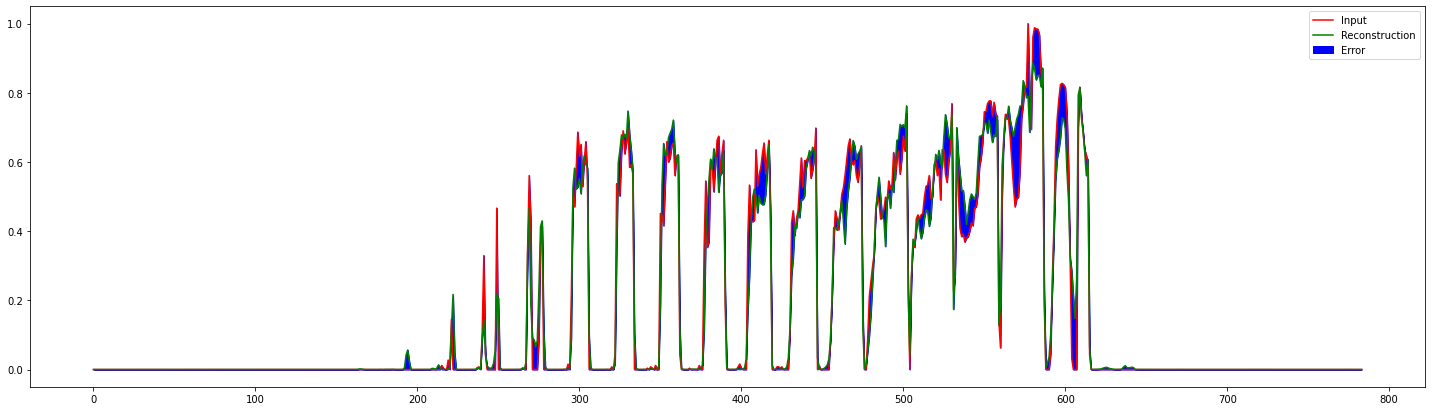

In [138]:
plt.figure(figsize=(25,7))
plt.plot(normal_test_data[0].ravel(), 'r')
plt.plot(decoded_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_data[0].ravel(), normal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

In [139]:
encoded_abn_data = autoencoder.encoder(abnormal_test_data).numpy()
decoded_abn_data = autoencoder.decoder(encoded_abn_data).numpy()

**1-Dim plot of pixels of the first abnormal test data**

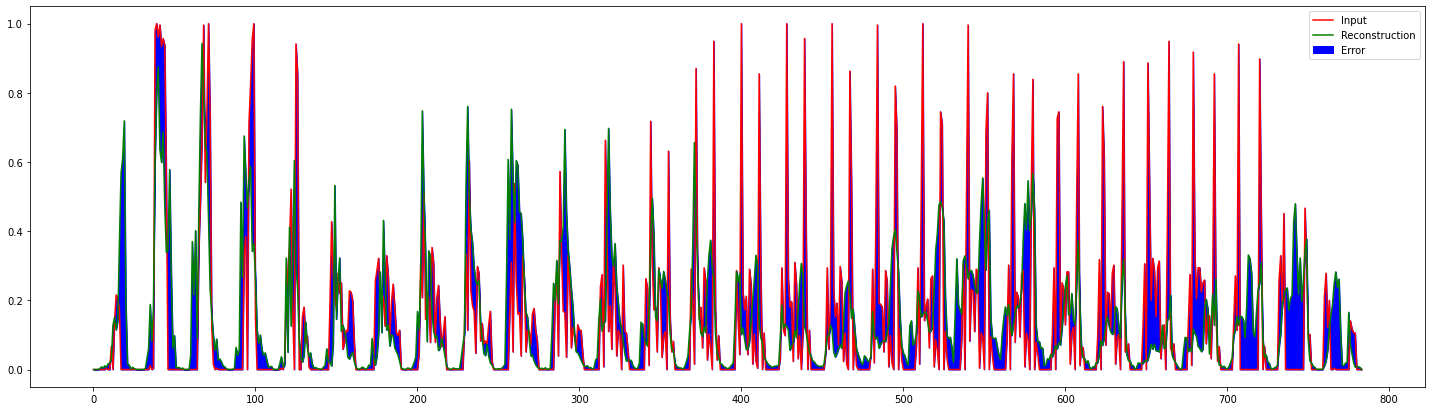

In [140]:
plt.figure(figsize=(25,7))
plt.plot(abnormal_test_data[0].ravel(), 'r')
plt.plot(decoded_abn_data[0].ravel(), 'g')
plt.fill_between(np.arange(28*28), decoded_abn_data[0].ravel(), abnormal_test_data[0].ravel(), color='blue')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### **Distributions of the reconstruction losses and the calculation of the threshold.**

**Distribution of the reconstruction losses of the normal training data**



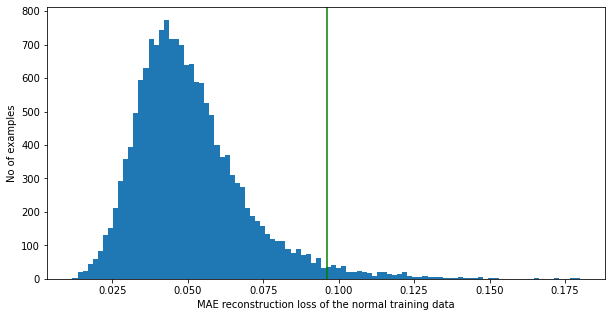

In [141]:
reconstructions = autoencoder.predict(normal_data)
train_loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), normal_data.reshape(-1, 784))
plt.figure(figsize=(10,5))
plt.hist(train_loss[None,:], bins=100)
threshold1 = np.mean(train_loss) + 2.5*np.std(train_loss)
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the normal training data")
plt.ylabel("No of examples")
plt.show()

In [142]:
mean1 = np.mean(train_loss)
std1 = np.std(train_loss)
print("Mean: ", mean1)
print("Std: ", std1)

Mean:  0.050682
Std:  0.018153412


In [143]:
threshold_train_mean_2_5_std = np.mean(train_loss) + 2.5*np.std(train_loss)
print("Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std: ", threshold_train_mean_2_5_std)

Threshold based on the mean of the training data MAE reconstruction losses + 2.5 std:  0.0960655314847827


In [144]:
threshold1 = threshold_train_mean_2_5_std

**Distribution of the reconstruction losses of the abnormal validation data**



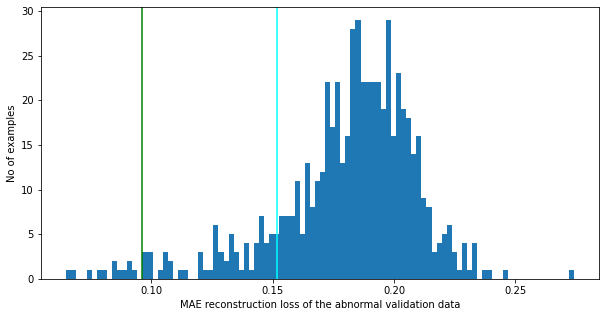

In [145]:
reconstructions = autoencoder.predict(abnormal_valid_data)
abn_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_valid_data.reshape(-1,784))
plt.figure(figsize=(10,5))
plt.hist(abn_valid_loss[None, :], bins=100)
threshold2 = np.mean(abn_valid_loss) - np.std(abn_valid_loss)
plt.axvline(threshold2,c='cyan')
plt.axvline(threshold1,c='g')
plt.xlabel("MAE reconstruction loss of the abnormal validation data")
plt.ylabel("No of examples")
plt.show()

In [146]:
abnormal_valid_mean_loss = np.mean(abn_valid_loss)

In [147]:
abnormal_valid_mean_loss , np.std(abn_valid_loss)

(0.18096264, 0.029219516)

In [148]:
threshold2 = abnormal_valid_mean_loss - np.std(abn_valid_loss)
print("Threshold2: ", threshold2)

Threshold2:  0.15174311


**Distribution of the reconstruction losses of the normal validation data**

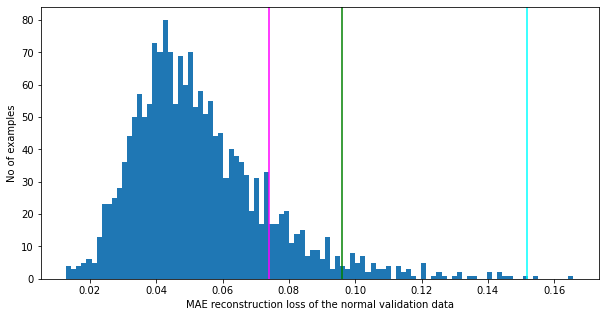

In [149]:
reconstructions = autoencoder.predict(normal_valid_data)
nl_valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), normal_valid_data.reshape(-1,784))
plt.figure(figsize=(10,5))
plt.hist(nl_valid_loss[None, :], bins=100)
threshold3 = np.mean(nl_valid_loss) + np.std(nl_valid_loss)
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold1, c='g')
plt.xlabel("MAE reconstruction loss of the normal validation data")
plt.ylabel("No of examples")
plt.show()

In [150]:
normal_valid_mean_loss = np.mean(nl_valid_loss)

In [151]:
normal_valid_mean_loss , np.std(nl_valid_loss)

(0.053276606, 0.020718832)

In [152]:
threshold3 = normal_valid_mean_loss + np.std(nl_valid_loss)
print("Threshold3: ", threshold3)

Threshold3:  0.07399544


**Calculation of a preliminary threshold based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)**

In [153]:
Avg_of_threshold_2_3 = (threshold2 + threshold3)/2
print("Average of threshold 2 and 3: ", Avg_of_threshold_2_3)

Average of threshold 2 and 3:  0.1128692775964737


In [154]:
threshold4 = Avg_of_threshold_2_3

### **Calculation of the threshold that gives the best accuracy on the validation data and set this as the threshold.**

In [155]:
def predict(model, data, threshold):
  reconstructions = model.predict(data)
  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
  return tf.math.less(loss, threshold)

In [156]:
increment = (abnormal_valid_mean_loss- normal_valid_mean_loss)/100
thresholds = np.arange(normal_valid_mean_loss, abnormal_valid_mean_loss, increment)
thrs_size = thresholds.shape[0]
accuracies = np.zeros(thrs_size)
for i in range(thrs_size):
  preds = predict(autoencoder, valid_data, thresholds[i])
  accuracies[i] = accuracy_score(preds, valid_labels_T_F)
argmax = np.argmax(accuracies)
valid_data_best_threshold = thresholds[argmax]
print("The best threshold based on validation data: ", valid_data_best_threshold)

The best threshold based on validation data:  0.12095019847154628


In [157]:
thr_acc = np.zeros((thrs_size, 2))
thr_acc[:, 0] = thresholds
thr_acc[:, 1] = accuracies
thr_acc[argmax-2:argmax+3]

array([[0.11839648, 0.97966805],
       [0.11967334, 0.97966805],
       [0.1209502 , 0.9813278 ],
       [0.12222706, 0.98008299],
       [0.12350392, 0.98008299]])

In [158]:
threshold5 = valid_data_best_threshold

In [159]:
threshold = threshold5

#### **Distribution of the reconstruction losses of all the validation data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

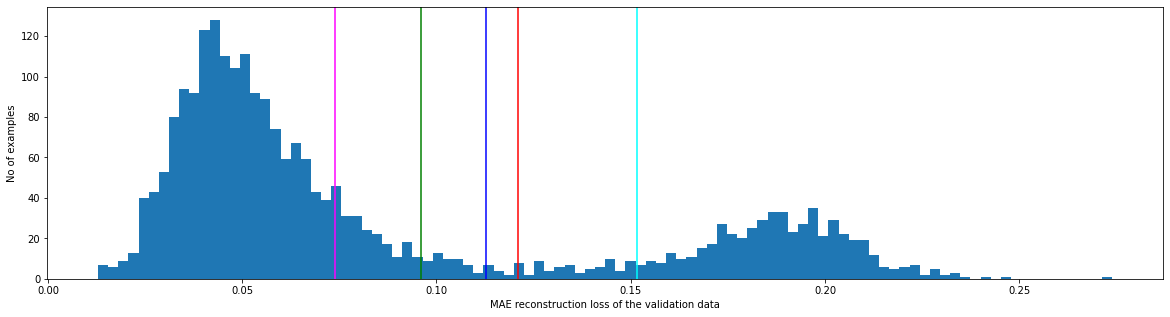

In [160]:
reconstructions = autoencoder.predict(valid_data)
valid_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), valid_data.reshape(-1,784))
plt.figure(figsize=(20,5))
plt.hist(valid_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the validation data")
plt.ylabel("No of examples")
plt.show()

#### **Distribution of the reconstruction losses of the test data (normal and abnormal)**

The blue line is threshold4 (= the average of threshold3 [magenta] and threshold2 [cyan]). 

The red line is the threshold that gives the best accuracy for the validation data.

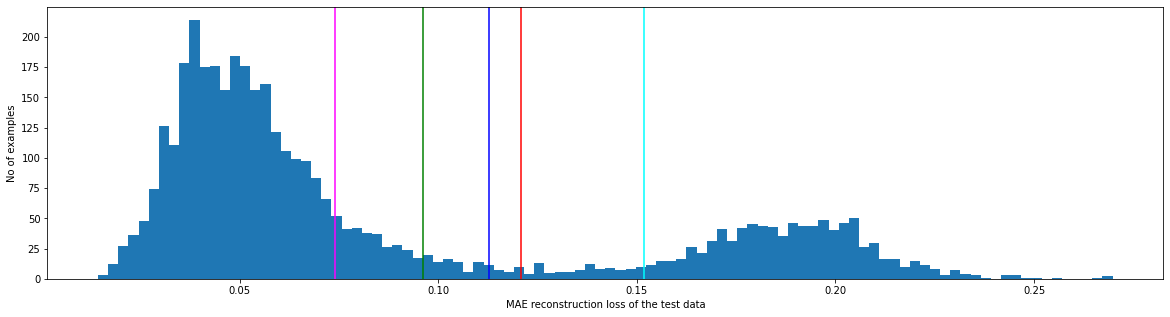

In [161]:
reconstructions = autoencoder.predict(test_data)
test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), test_data.reshape(-1,784))
plt.figure(figsize=(20,5))
plt.hist(test_loss[None, :], bins=100)
plt.axvline(threshold, c='r')
plt.axvline(threshold4, c='b')
plt.axvline(threshold2, c='cyan')
plt.axvline(threshold3, c='magenta')
plt.axvline(threshold1, c='green')
plt.xlabel("MAE reconstruction loss of the test data")
plt.ylabel("No of examples")
plt.show()

In [162]:
reconstructions = autoencoder.predict(normal_test_data)
nl_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), normal_test_data.reshape(-1,784))
np.mean(nl_test_loss) , np.std(nl_test_loss)

(0.053497862, 0.021043148)

In [163]:
reconstructions = autoencoder.predict(abnormal_test_data)
abn_test_loss = tf.keras.losses.mae(reconstructions.reshape(-1,784), abnormal_test_data.reshape(-1,784))
np.mean(abn_test_loss) , np.std(abn_test_loss)

(0.18297648, 0.02837885)

### **Calculation of the accuracy and the confusion matrix on the test data with threshold set based on the best threshold from the validation data**

In [164]:
# def predict(model, data, threshold):
#  reconstructions = model.predict(data)
#  loss = tf.keras.losses.mae(reconstructions.reshape(-1, 784), data.reshape(-1, 784))
#  return tf.math.less(loss, threshold)

mean_nl_test_loss = np.mean(nl_test_loss)
std_nl_test_loss = np.std(nl_test_loss)

mean_abn_test_loss = np.mean(abn_test_loss)
std_abn_test_loss = np.std(abn_test_loss)

def print_stats(predictions, labels):
  cf = confusion_matrix(labels, predictions)

  print("mean_nl_test_loss: {}".format(mean_nl_test_loss))
  print("std_nl_test_loss: {}".format(std_nl_test_loss))
  print("mean_abn_test_loss: {}".format(mean_abn_test_loss))
  print("std_abn_test_loss: {}".format(std_abn_test_loss))

  print("Confusion Matrix: \n prediction: F      T ")
  print("             {}   {}".format(preds[preds == False].shape[0], preds[preds == True].shape[0]))
  print(" label: F   [[{}   {}]    {}".format(cf[0,0], cf[0,1], test_labels_T_F[test_labels_T_F == False].shape[0]))
  print("        T    [{}   {}]]   {}".format(cf[1,0], cf[1,1], test_labels_T_F[test_labels_T_F == True].shape[0]))
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))
  

In [165]:

preds = predict(autoencoder, test_data, valid_data_best_threshold)
print_stats(preds, test_labels_T_F)

mean_nl_test_loss: 0.053497862070798874
std_nl_test_loss: 0.021043147891759872
mean_abn_test_loss: 0.18297648429870605
std_abn_test_loss: 0.02837884984910488
Confusion Matrix: 
 prediction: F      T 
             995   3005
 label: F   [[960   40]    1000
        T    [35   2965]]   3000
Accuracy = 0.98125
Precision = 0.9866888519134775
Recall = 0.9883333333333333


In [166]:
print(confusion_matrix(test_labels_T_F, preds))

[[ 960   40]
 [  35 2965]]


#### **Extra accuracy info**
**Just informative. Please record the above accuracy.**

#### Accuracy on the test data with threshold set based on (threshold2 + threshold3) / 2 = Average of (mean + std of the distribution of the reconstruction losses of the normal validation data) and (mean - std of the distribution of the reconstruction losses of the abnormal validation data)

In [167]:
preds = predict(autoencoder, test_data, Avg_of_threshold_2_3)
print_stats(preds, test_labels_T_F)

mean_nl_test_loss: 0.053497862070798874
std_nl_test_loss: 0.021043147891759872
mean_abn_test_loss: 0.18297648429870605
std_abn_test_loss: 0.02837884984910488
Confusion Matrix: 
 prediction: F      T 
             1021   2979
 label: F   [[968   32]    1000
        T    [53   2947]]   3000
Accuracy = 0.97875
Precision = 0.9892581403155422
Recall = 0.9823333333333333


#### Accuracy on the test data with threshold set based on the mean of the training data MAE reconstruction losses + 2.5 std

In [168]:
preds = predict(autoencoder, test_data, threshold_train_mean_2_5_std)
print_stats(preds, test_labels_T_F)

mean_nl_test_loss: 0.053497862070798874
std_nl_test_loss: 0.021043147891759872
mean_abn_test_loss: 0.18297648429870605
std_abn_test_loss: 0.02837884984910488
Confusion Matrix: 
 prediction: F      T 
             1110   2890
 label: F   [[980   20]    1000
        T    [130   2870]]   3000
Accuracy = 0.9625
Precision = 0.9930795847750865
Recall = 0.9566666666666667
